#### Инициализация

In [1]:
'''Импорт библиотек'''
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import cv2
#pip install opencv-python
import numpy as np
from lmfit.models import GaussianModel
gauss = GaussianModel()

'''Подавление предупреждений срабатывания lmfit.GaussModel.guess() -- она создаёт UFloat'''
import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0")

'''Частота излучения и сечение поглощения'''
frequency = 709078373.01 * 10 ** 6 # [Hz]
c = 299792458 # [m/s]
wavelength = (c/frequency) * 10 ** 2 # [cm]
crossection = (3 * wavelength ** 2 ) / (2 * np.pi) # [cm^2]

rows, columns = (768, 1024)
'''Калибровка'''# [cm/px]
K = 0.0008332755449029944

#### Обработка поглощения

In [2]:
file = "image_5"
#directory = r"../" # EXPERIMENTS
#directory = r"../../" # Desktop
directory = r"../2025-10-10_densityScan_b=35/d=6.37V/"

'''Чтение и разбиение файла'''
img = PIL.Image.open(directory + file + ".tif") # чёрно-белое изображение

shots = []
try:
    while True:
        frame = np.array(img)
        shots.append(frame)
        img.seek(img.tell() + 1) # перейти к новому кадру
except EOFError: # кадры закончились 
    pass

I_atoms = shots[0] #I
I_lbeam = shots[1] #I0
bias = shots[2]

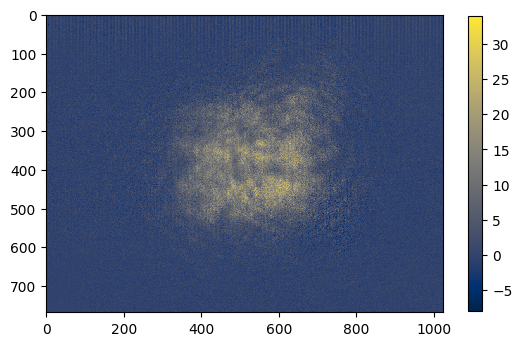

In [3]:
'''Приведение к uint16 и замена нулей, чтобы не возникало ошибок при делении матриц'''
num = (I_atoms - bias).astype(np.uint16) + 1
denom = (I_lbeam - bias).astype(np.uint16) + 1

'''Определение пропускания T(x,y)'''
T = (num/denom).astype(np.float32)

'''Фильтрация физичных T'''
T = np.clip(T, 0, 1)  # из-за деления возникают значения вплоть до 256.

'''Визуализация лучей'''
D = I_lbeam.astype(np.int16)-I_atoms.astype(np.int16)
plt.imshow(D, cmap="cividis", interpolation="none")
plt.colorbar(shrink=.8)

#### Поиск центра облака

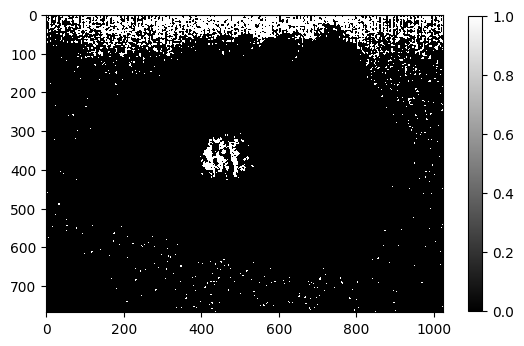

In [4]:
'''Фильтрация физичных T<=1'''
F = np.copy(T)
for i in range(rows):
    for j in range(columns):
        if T[i, j] > 1:
            F[i, j] = 1

'''Медианное сглаживание шумов'''
M = cv2.medianBlur(F, 5)

TRSH = .81
'''Фильтрация пропускания ниже порогового значения'''
_, binary = cv2.threshold(M, TRSH, 1, cv2.THRESH_BINARY_INV)
# THRESH_BINARY_INV:
#  ≤ TRSH = белые
#  > TRSH = чёрные

'''Визуализация'''
plt.imshow(binary, cmap="gray", interpolation='none')
plt.colorbar(shrink=.8)

Центральное пропускание	Tc: 0.8194444179534912
Центральная точка	C: (375, 431) 


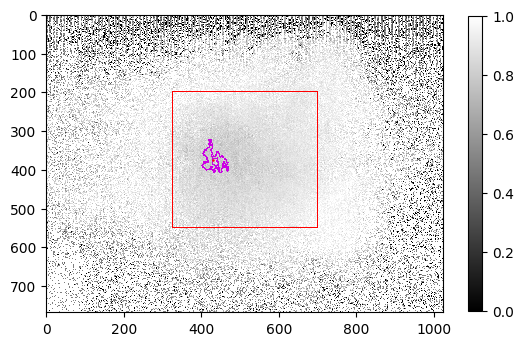

In [5]:
'''Выделение контура поглощения'''
contours, _ = cv2.findContours(binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
assert contours != (), "Err: no contours found"

'''Ограничивающий прямоугольник'''
j_min = 325
i_min = 200
width = 375
height = 350
j_max = j_min + width
i_max = i_min + height

'''Фильтрация шумных контуров'''
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if y>i_min and x>j_min and y<i_max and x<j_max:
        filtered_contours.append(contour)
assert filtered_contours != (), "Err: no contours meet filtering criteria"

'''Формирование маски'''
largest_contour = max(filtered_contours, key=cv2.contourArea)
ROI = np.zeros_like(T, dtype=np.uint8)
cv2.drawContours(ROI, [largest_contour], -1, 255, thickness=cv2.FILLED)

'''Нахождение репера фитирования'''
#min_val, _, (jc, ic), _ = cv2.minMaxLoc(T, mask=ROI)
M = cv2.moments(largest_contour)
assert M["m00"] != 0, "Err: no centroid found"
jc = int(M["m10"] / M["m00"])
ic = int(M["m01"] / M["m00"])
print(f"Центральное пропускание\tTc: {T[ic, jc]}\nЦентральная точка\tC: {(ic, jc)} ")

'''Область фитирования'''
#j_min, i_min, width, height = cv2.boundingRect(largest_contour)
j_min = 325
i_min = 200
width = 375
height = 350
j_max = j_min + width
i_max = i_min + height

'''Отрисовка полученного контура'''
img_contour = cv2.cvtColor(T, cv2.COLOR_GRAY2BGR)  # opencv рисует в формате BGR
cv2.drawContours(img_contour, [largest_contour], -1, (.9, 0, .8), 2)
cv2.rectangle(img_contour, (j_min, i_min), (j_max, i_max), (0, 0, 1.), 2)
img_contour = cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB)
plt.imshow(img_contour, interpolation='none', cmap="gray")
plt.plot(jc, ic, 'ro', markersize=.75)
plt.colorbar(shrink=.8)

#### Обработка центральных осей

fwhmx: 337.864 ± 10.876 px
peak absorption: 80.678% ± 0.324%
________________________________
χ²-reduced: 0.001
>1 -- model lacks freedom
<1 -- model has too much freedom (overfit)


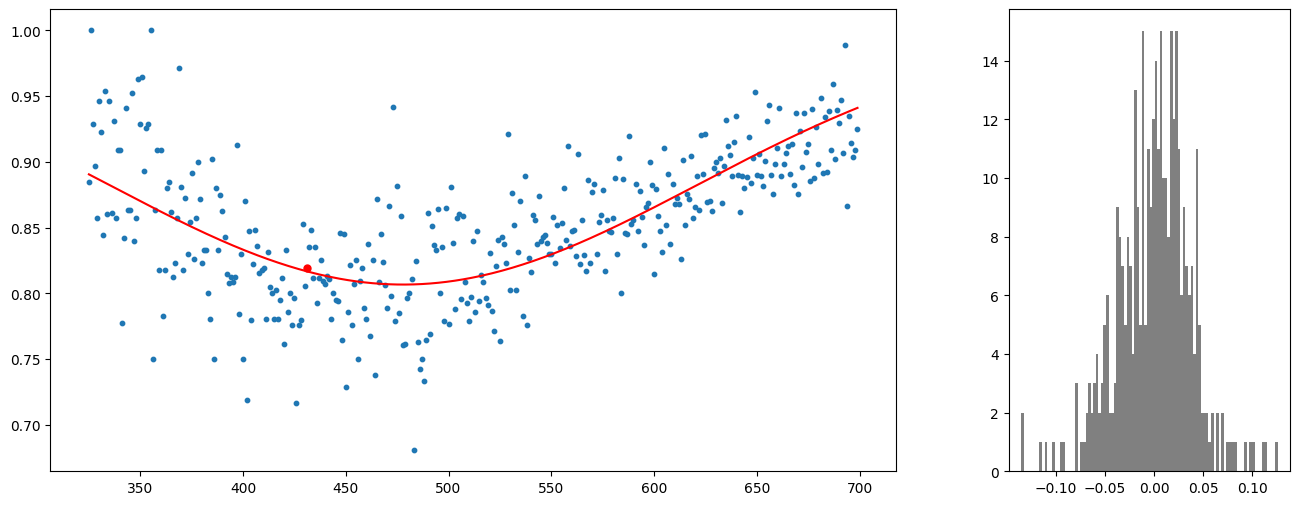

In [6]:
'''Профиль по оси j (для величины wx)'''
data = 1-T[ic, j_min:j_max] # без медианного сглаживания шумы слишком сильные, чтобы сигнал был различим
arg = np.arange(j_min, j_max, 1)

'''Фитирование нормальным распределением'''
pars = gauss.guess(data, x=arg) # затравочные параметры
out = gauss.fit(data, pars, x=arg, calc_covar=False)

residuals = data - out.best_fit
wx = out.params["sigma"].value
fwhmx = out.params["fwhm"].value
peak = 1-out.params["height"].value

'''Вывод фитирования'''
print("fwhmx: %.3f ± %.3f px" % (fwhmx, out.params["fwhm"].stderr))  #stderr соответствует p = 0.68 (1-сигма)
#print("wx: %.3f ± %.3f px" % (wx, out.params["sigma"].stderr))
print("peak absorption: %.3f%% ± %.3f%%" % (peak*100, out.params["height"].stderr*100))
print("________________________________")
print("χ²-reduced: \033[31m%.3f\033[0m" % out.redchi)
print(">1 -- model lacks freedom")
print("<1 -- model has too much freedom (overfit)")
#print("Fit explains \033[31m%.3f\033[0m%% of data (R² param)" % (out.rsquared*100))

'''Визуализация'''
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 6))
ax[0].scatter(arg, 1-data, s=10)
ax[0].plot(arg, 1-out.best_fit, "r-")
ax[0].plot(jc, 1-data[jc-j_min], 'r.', markersize=10)
ax[1].hist(residuals.flatten(), bins=100, color="gray")
plt.show()

fwhmy: 297.124 ± 10.525 px
________________________________
χ²-reduced: 0.002
>1 -- model lacks freedom
<1 -- model has too much freedom (overfit)


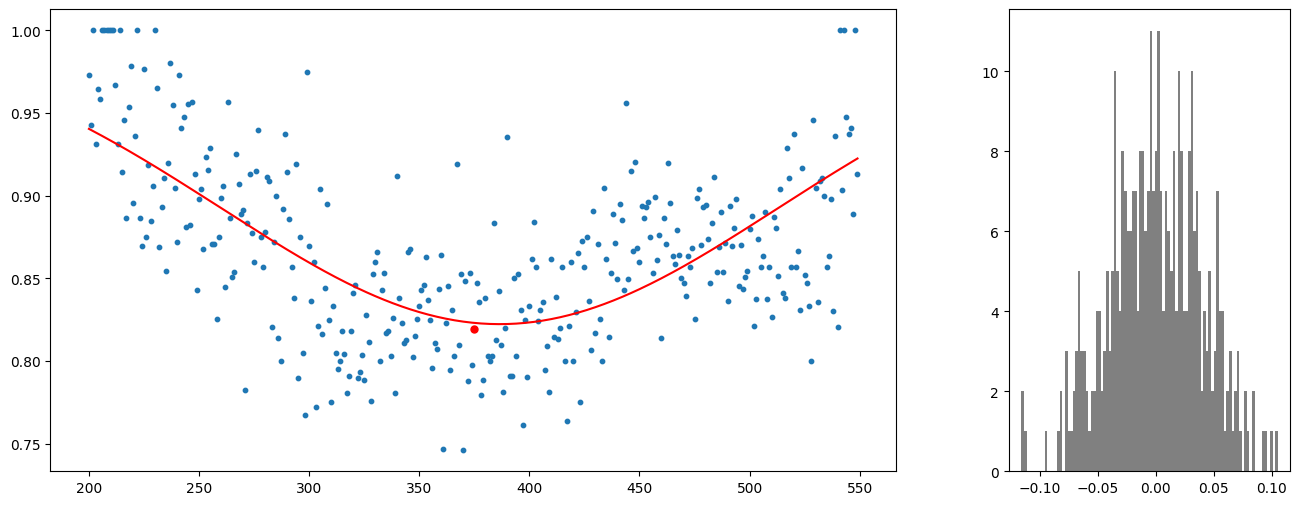

In [7]:
'''Профиль по оси i (для величины w_y)'''
data = 1-T[i_min:i_max, jc]
arg = np.arange(i_min, i_max, 1)

'''Фитирование нормальным распределением'''
pars = gauss.guess(data, x=arg)
out = gauss.fit(data, pars, x=arg, calc_covar=False)

residuals = data - out.best_fit
wy = out.params["sigma"].value
fwhmy = out.params["fwhm"].value

'''Вывод фитирования'''
print("fwhmy: %.3f ± %.3f px" % (fwhmy, out.params["fwhm"].stderr))
print("________________________________")
print("χ²-reduced: \033[31m%.3f\033[0m" % out.redchi)
print(">1 -- model lacks freedom")
print("<1 -- model has too much freedom (overfit)")
#print("Fit explains \033[31m%.3f\033[0m%% of data (R² param)" % (out.rsquared*100))

'''Визуализация'''
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 6))
ax[0].scatter(arg, 1-data, s=10)
ax[0].plot(arg, 1-out.best_fit, "r-")
ax[0].plot(ic, 1-data[ic-i_min], 'r.', markersize=10)
ax[1].hist(residuals.flatten(), bins=100, color="gray")
plt.show()

#### Расчёт концентрации

n0: 7.79e+08 cm^-3
N:  1.84e+07 cm^-3
FWHMx:  2.82 mm


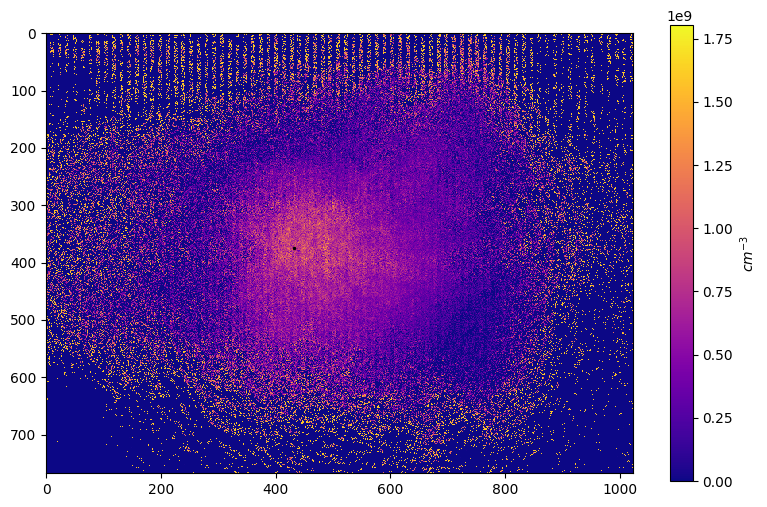

In [11]:
'''Профиль концентрации атомов n(x, y)'''
n = -np.log(T)/(np.sqrt(2*np.pi)*wx*K*crossection).astype(np.float32)

'''Порог фильтрации'''
_, nm, _, _ = cv2.minMaxLoc(n, mask=ROI)
'''Пиковая плотность'''
n0 = -np.log(T[ic, jc])/(np.sqrt(2*np.pi)*wx*K*crossection).astype(np.float32)
'''Число атомов во всём облаке'''
N = -(2*np.pi*wx*K*wy*K*np.log(T[ic, jc])/crossection).astype(np.float32)

'''Вывод значений'''
print("n0: %.2e cm^-3" % n0)
print("N:  %.2e cm^-3" % N)
print("FWHMx:  %.2f mm" % (fwhmx*K*10))

'''Фильтрация физичных плотностей'''
for i in range(rows): #rows
    for j in range(columns): #columns
        if n[i, j] < 0.:
            n[i, j] = 0.
        elif n[i, j] > nm:
            n[i, j] = 0.

'''Визуализация'''
plt.figure(figsize=(8, 6))
plt.imshow(n, cmap="plasma", interpolation="none")
plt.plot(jc, ic, 'ko', markersize=1.5)
plt.colorbar(shrink=.8, label="$cm^{-3}$")
plt.tight_layout()
plt.show()
#plt.savefig(directory + file + "_n0=%.3e.png"%n0)